<a href="https://colab.research.google.com/github/VolkhinD/Houses/blob/main/Copy_of_houses_begining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Regression Model with XGBoost 

# Begginning 

In [ ]:
import sys
!{sys.executable} -m pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error as MSLE, mean_absolute_error
from sklearn.compose import make_column_transformer, make_column_selector as selector
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

Download Data

In [ ]:
path = '/content/train.csv'
path1 = '/content/test.csv'
df = pd.read_csv(path)
df_test = pd.read_csv(path1)
print(df.shape, df_test.shape)

(1460, 81) (1459, 80)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Work with Data

  Working with all columns I devided them into 3 categories: strong, good and not important for target based on my opinion only. Later I will be using different types of feature selection. \
 I left only 26 features and created 1 new: total number of bathrooms. 

 ## Understand Data

MSSubClass: The building class 
The biggest prices from 60

MSZoning: The general zoning classification

LotFrontage: Linear feet of street connected to property
not important

LotArea: Lot size in square feet
no

Street: Type of road access
Just 2 values no

Alley: Type of alley access
1369 Null values

LotShape: General shape of property
no

LandContour: Flatness of the property
no

Utilities: Type of utilities available
just 1! different value

LotConfig: Lot configuration
no

LandSlope: Slope of property
no

Neighborhood: Physical locations within Ames city limits
good

Condition1: Proximity to main road or railroad
yes

Condition2: Proximity to main road or railroad (if a second is present)
didn't get it, no

BldgType: Type of dwelling
yes

HouseStyle: Style of dwelling
yes

OverallQual: Overall material and finish quality
STRONG

OverallCond: Overall condition rating
Categorical values
yes

YearBuilt: Original construction date
yes

YearRemodAdd: Remodel date
Works with prev feature, check

RoofStyle: Type of roof
yes

RoofMatl: Roof material
yes

Exterior1st: Exterior covering on house
?

Exterior2nd: Exterior covering on house (if more than one material)
?

MasVnrType: Masonry veneer type
no

MasVnrArea: Masonry veneer area in square feet

ExterQual: Exterior material quality
yes

ExterCond: Present condition of the material on the exterior
no

Foundation: Type of foundation
no

BsmtQual: Height of the basement
yes 37 NULL

BsmtCond: General condition of the basement
no 37 NULL

BsmtExposure: Walkout or garden level basement walls
no NULL

BsmtFinType1: Quality of basement finished area
no NULL

BsmtFinSF1: Type 1 finished square feet
no

BsmtFinType2: Quality of second finished area (if present)
no NULLS

BsmtFinSF2: Type 2 finished square feet
no

BsmtUnfSF: Unfinished square feet of basement area
no

TotalBsmtSF: Total square feet of basement area
STRONG

Heating: Type of heating
yes

HeatingQC: Heating quality and condition
yes 

CentralAir: Central air conditioning
yes

Electrical: Electrical system
1 NULL yes

1stFlrSF: First Floor square feet
STRONG

2ndFlrSF: Second floor square feet
STRONG

LowQualFinSF: Low quality finished square feet (all floors)
no

GrLivArea: Above grade (ground) living area square feet
STRONG

BsmtFullBath: Basement full bathrooms
'3' just ones so delete pandas thinks it's num 
no

BsmtHalfBath: Basement half bathrooms
pandas thinks it's num 
no

FullBath: Full bathrooms above grade
pandas thinks it's num 

HalfBath: Half baths above grade
объеденить с FullBath

BedroomAbvGr: Number of bedrooms above basement level
yes

KitchenAbvGr: Number of kitchens
no

KitchenQual: Kitchen quality
STRONG

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
STRONG

Functional: Home functionality rating
no

Fireplaces: Number of fireplaces
yes

FireplaceQu: Fireplace quality
no NULLs

GarageType: Garage location
yes NULLS

GarageYrBlt: Year garage was built
NULLs no

GarageFinish: Interior finish of the garage
no

GarageCars: Size of garage in car capacity
no 

GarageArea: Size of garage in square feet
yes

GarageQual: Garage quality
no

GarageCond: Garage condition
no

PavedDrive: Paved driveway
no

WoodDeckSF: Wood deck area in square feet
no

OpenPorchSF: Open porch area in square feet
no

EnclosedPorch: Enclosed porch area in square feet
1252 values is 0 no

3SsnPorch: Three season porch area in square feet
no, many 0

ScreenPorch: Screen porch area in square feet
no

PoolArea: Pool area in square feet
no, 1453 0s

PoolQC: Pool quality
no

Fence: Fence quality
no

MiscFeature: Miscellaneous feature not covered in other categories
no

MiscVal: $Value of miscellaneous feature
no

MoSold: Month Sold
no

YrSold: Year Sold
no

SaleType: Type of sale
yes

SaleCondition: Condition of sale
no

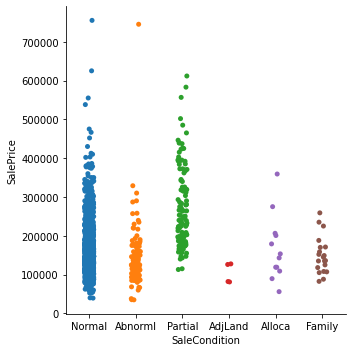

In [ ]:
sns.catplot(x="SaleCondition", y="SalePrice", data=df)

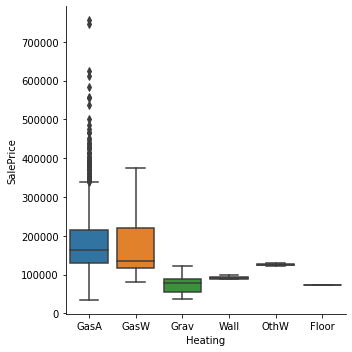

In [ ]:
sns.catplot(x='Heating', y="SalePrice", data=df, kind='box')

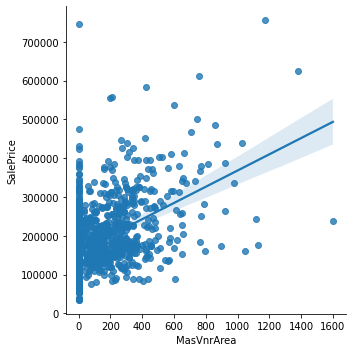

In [ ]:
sns.lmplot(x= 'OpenPorchSF', y="SalePrice", data=df)

# Feature Selection

Set 'Id' as an index

In [ ]:
df = df.set_index('Id')


Add a new feature: total number of Bathrooms in a house

In [ ]:
df['BathNum'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath']
y = df.SalePrice
df = df.drop('SalePrice', axis=1)

### **Based on my opinion**

In [ ]:
num_feat = ['LotFrontage', 'LotArea',  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal']
cat_feat = list(set(df.columns) - set(num_feat))
strong_feat = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd', 'BathNum']
good_feat = ['Condition1', 'BldgType', 'HouseStyle', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
            'ExterQual', 'ExterQual', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BedroomAbvGr', 'MasVnrArea',
             'Fireplaces', 'GarageArea', 'SaleType'] + strong_feat
good_cat_feat = list(set(good_feat) & set(cat_feat))
good_num_feat = list(set(good_feat) - set(good_cat_feat))
good_data = df[good_feat]
strong = df[strong_feat]
len(good_feat)


27

### **Univariate statistics**

In [ ]:
selector1 = SelectPercentile(f_regression, percentile=50)
uni_pipe = Pipeline([('imputer', SimpleImputer()), ('selector', selector1)])
uni_pipe.fit(df[num_feat], y)
X_univar = uni_pipe.transform(df[num_feat])
uni_pipe.feature_names_in_
X_univar = pd.DataFrame(X_univar)

### **Model-based selection** 
There is raw data so lets start with basic feature work: \


In [ ]:

num_chan = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True))
cat_chan = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),)

num_chan_tree = SimpleImputer(strategy="mean", add_indicator=True)
cat_chan_tree = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),)

linear_changer = make_column_transformer(
    (num_chan, selector(dtype_include="number")),
    (cat_chan, selector(dtype_include="category")),)

tree_changer = make_column_transformer(
    (num_chan_tree, selector(dtype_include="number")),
    (cat_chan_tree, selector(dtype_include="category")),)

In [ ]:
selector2 = SelectFromModel(Lasso(), max_features=40)
selector3 = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), max_features=40)
lasso_pipe = Pipeline([('changer', linear_changer), ('selector', selector2)])
forest_pipe = Pipeline([('changer', tree_changer), ('selector', selector3)])

lasso_pipe.fit(df, y)
X_lasso = pd.DataFrame(lasso_pipe.transform(df))


In [ ]:
forest_pipe.fit(df, y)
X_forest = pd.DataFrame(forest_pipe.transform(df))

In [ ]:
X_forest.shape

(1460, 7)

Lasso kept 40 features, Random Forst kept only 7

### **Iterative selection, Recursive Feature Elimination, RFE)**

In [ ]:
selector4 = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=40)
selector5 = RFE(LinearRegression(), n_features_to_select=40)

rfe_pipe = Pipeline([('changer', tree_changer), ('selector', selector4)])
rfe_pipe.fit(df, y)
X_rfe_forest = pd.DataFrame(rfe_pipe.transform(df))

selector5 = RFE(LinearRegression(), n_features_to_select=40)
rfe_lin_pipe = Pipeline([('changer', linear_changer), ('selector', selector5)])
X_rfe_lin = pd.DataFrame(rfe_lin_pipe.fit_transform(df, y))

## Catching NULL values

BsmtQual and BsmtCond add new value 'No Bsmt'
GarageType add new 'No Garage'


In [ ]:
for row in good_feat:
    if strong[row].isnull().sum():
        print(row)
        print(strong[row].isnull().sum())

In [ ]:
good_data.isnull().sum()

MasVnrArea      8 \
Electrical      1

## Heatmaps 

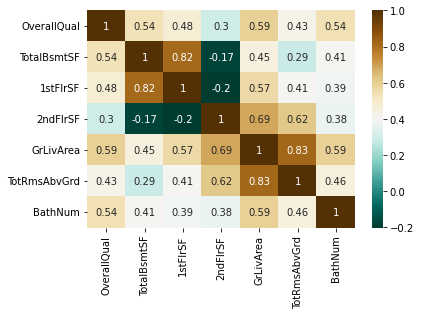

In [ ]:
sns.heatmap(strong.corr(), cmap = 'BrBG_r',annot=True)

In [ ]:
strong.pop('GrLivArea')

Id
1       1710
2       1262
3       1786
4       1717
5       2198
        ... 
1456    1647
1457    2073
1458    2340
1459    1078
1460    1256
Name: GrLivArea, Length: 1460, dtype: int64

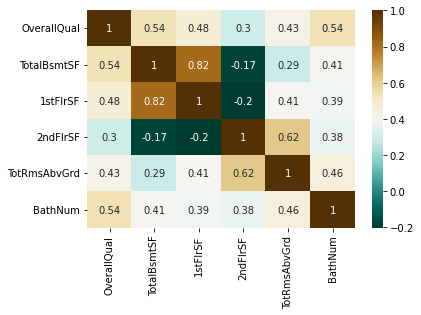

In [ ]:
sns.heatmap(strong.corr(), cmap = 'BrBG_r',annot=True)

# Catching Outliners 

1. To see outliners use RobustScaler 

## Research Distribution

# Preprocessing and Base Pipelines

In [ ]:
model = XGBRegressor()
strong = df[strong_feat]
good = df[good_feat]

To GridSearch: n_estimators[100, 700, 1000], max_depth = [3, 6, 9]


In [ ]:
pipe1.get_params().keys()

In [ ]:
param_grid = {'model__n_estimators': [100, 300, 500, 700], 
              'model__max_depth':[3, 6, 9]}
grid = GridSearchCV(pipe2, param_grid, cv=5, scoring='neg_mean_squared_log_error')
grid.fit(strong, y)
print(grid.best_estimator_)

In [ ]:
selected_data = [X_univar, X_lasso, X_forest, X_rfe_forest, X_rfe_lin]

In [ ]:
scores = {'neg_mean_absolute_error': []}
index = []
result = cross_val_score(model, X=X_univar, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Univariate statistics']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866


In [ ]:
result = cross_val_score(model, X=X_lasso, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Model-Based Lasso']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:17:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922


In [ ]:
result = cross_val_score(model, X=X_forest, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Model-Based Random Forest']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922
Model-Based Random Forest,-19993.589116


In [ ]:
result = cross_val_score(model, X=X_rfe_forest, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['RFE Random Forest']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922
Model-Based Random Forest,-19993.589116
RFE Random Forest,-16734.935336


In [ ]:
result = cross_val_score(model, X=X_rfe_lin, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['RFE Linear']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922
Model-Based Random Forest,-19993.589116
RFE Random Forest,-16734.935336
RFE Linear,-16736.699922


In [ ]:
num_pre = StandardScaler()
cat_pre = OneHotEncoder()
preprocesser_strong = make_column_transformer(
    (num_pre, selector(dtype_include="number")),
    (cat_pre, selector(dtype_include="category")),)

pipe_hand = Pipeline([('preprocessing', preprocesser_strong), ('model', model)])

result = cross_val_score(pipe_hand, X=strong, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Hand choise Strong features']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922
Model-Based Random Forest,-19993.589116
RFE Random Forest,-16734.935336
RFE Linear,-16736.699922
Hand choise Strong features,-20988.492704


In [ ]:
# take preprocesser from previous chapter it also works in good features
tree_changer = make_column_transformer(
    (num_chan_tree, selector(dtype_include="number")),
    (cat_chan_tree, selector(dtype_include="category")),)
pipe_good = Pipeline([('preprocessing', tree_changer), ('model', model)])

result = cross_val_score(pipe_hand, X=good, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Hand choise Strong features']
scores['neg_mean_absolute_error'].append(result.mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

[22:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,neg_mean_absolute_error
Univariate statistics,-20523.416866
Model-Based Lasso,-16736.699922
Model-Based Random Forest,-19993.589116
RFE Random Forest,-16734.935336
RFE Linear,-16736.699922
Hand choise Strong features,-20988.492704
Hand choise Strong features,-17820.279045
